# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

This notebook is also available on [Google Collaboratory](https://colab.research.google.com/drive/1ym040cKkQf85epu80VtIkMXy3LpfYQky?usp=sharing) and [nbviewer](https://nbviewer.jupyter.org/github/lenskit/lkpy/blob/master/doc/GettingStarted.ipynb).

## Setup

We first import the LensKit components we need:

In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, knn
from lenskit.data import from_interactions_df
from lenskit.data.movielens import load_movielens_df

And Pandas is very useful:

In [2]:
import pandas as pd

The `pyprojroot` package makes it easy to find input data:

In [3]:
from pyprojroot.here import here

## Loading Data

We're going to use the ML-100K data set:

In [5]:
ml100k = load_movielens_df(here('data/ml-100k.zip'))
ml100k.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## Defining Algorithms

Let's set up two algorithms:

In [6]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

**Note 2:** our algorithms do not necessarily implement the `Recommender` interface, so we adapt them. This fills in a default candidate selector.

The code function looks like this:

In [7]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(from_interactions_df(train))
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [8]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ml100k[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

/Users/mde48/LensKit/lkpy/lenskit/lenskit/data/dataset.py:628: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1719361060788/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(


With the results in place, we can concatenate them into a single data frame:

In [9]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,1449,4.994975,2,1,ItemItem
1,1398,4.866851,2,2,ItemItem
2,511,4.845399,2,3,ItemItem
3,1512,4.805413,2,4,ItemItem
4,1594,4.788468,2,5,ItemItem


To compute our analysis, we also need to concatenate the test data into a single frame:

In [10]:
test_data = pd.concat(test_data, ignore_index=True)

We analyze our recommendation lists with a `RecListAnalysis`.  It takes care of the hard work of making sure that the truth data (our test data) and the recoommendations line up properly.

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [11]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ItemItem  2       100  0.081186
          6       100  0.288946
          8       100  0.082112
          10      100  0.364167
          14      100  0.182636

Now we have nDCG values!

In [12]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.132649
ItemItem    0.096963
Name: ndcg, dtype: float64

<Axes: xlabel='Algorithm'>

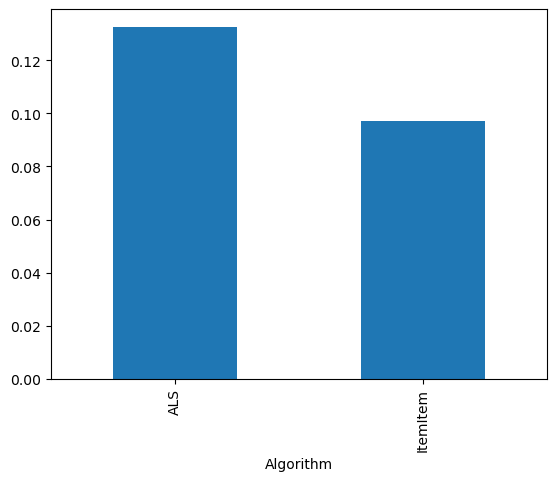

In [13]:
results.groupby('Algorithm').ndcg.mean().plot.bar()